In [17]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [47]:
transform = transforms.Compose([    
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root='cifar10', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='cifar10', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data,batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


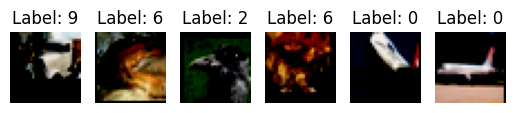

In [48]:
def show_images(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(nrows=1, ncols=6)
    for idx in range(6):
        ax = axes[idx]
        img = images[idx].permute(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis('off')
    plt.show()

show_images(train_loader)

In [49]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.5) 
        self.batch_norm1 = nn.BatchNorm2d(6) 
        self.batch_norm2 = nn.BatchNorm2d(16)
        
    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))  
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))  
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x))) 
        x = self.dropout(F.relu(self.fc2(x)))  
        x = self.fc3(x)
        return x
    
net = Net()

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),  lr=0.001, momentum= 0.9)

In [51]:
def Train(model, train_loader,criterion, optimizer, epochs):
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss+= loss.item()
            
        print(f"Epoch: {epoch+1}/{epochs}, Loss:{running_loss/len(train_loader)}")

In [55]:
Train(net, train_loader, criterion, optimizer, 50)

Epoch: 1/50, Loss:1.2412992814160368
Epoch: 2/50, Loss:1.2435034380087158
Epoch: 3/50, Loss:1.2389091029191566
Epoch: 4/50, Loss:1.239057769479654
Epoch: 5/50, Loss:1.234921361784191
Epoch: 6/50, Loss:1.22687222219794
Epoch: 7/50, Loss:1.2345330779204893
Epoch: 8/50, Loss:1.2313064800961244
Epoch: 9/50, Loss:1.2262678202765678
Epoch: 10/50, Loss:1.2259206848833568
Epoch: 11/50, Loss:1.2215714301447125
Epoch: 12/50, Loss:1.2114021464077103
Epoch: 13/50, Loss:1.2201252933353415
Epoch: 14/50, Loss:1.2178866361718044
Epoch: 15/50, Loss:1.2192076327245864
Epoch: 16/50, Loss:1.207318713674155
Epoch: 17/50, Loss:1.2082375169105237
Epoch: 18/50, Loss:1.2076366708406707
Epoch: 19/50, Loss:1.2081038919861053
Epoch: 20/50, Loss:1.207216698647765
Epoch: 21/50, Loss:1.206024795084658
Epoch: 22/50, Loss:1.2011825321885325
Epoch: 23/50, Loss:1.1999782175206772
Epoch: 24/50, Loss:1.1988793831042317
Epoch: 25/50, Loss:1.1989592267271807
Epoch: 26/50, Loss:1.1949540660966693
Epoch: 27/50, Loss:1.1962511

In [56]:
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100* correct / total}%")


test(net, test_loader)

Accuracy: 58.15%


In [64]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

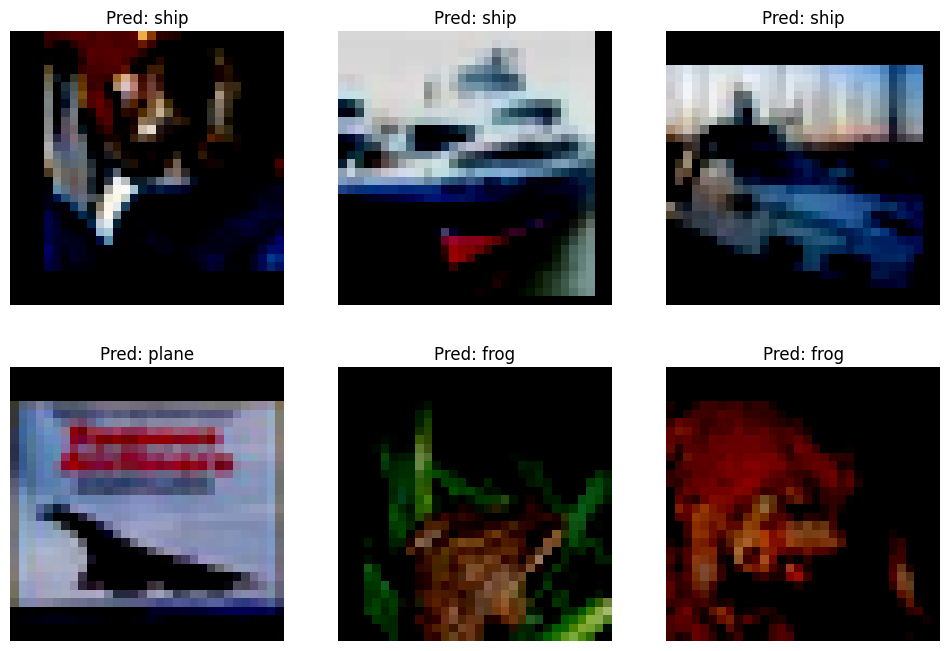

In [68]:
def show_predictions(model, test_loader):
    model.eval()  
    images, labels = next(iter(test_loader)) 
    outputs = model(images)  
    _, preds = torch.max(outputs, 1) 

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for idx in range(6):
        ax = axes[idx]
        ax.imshow(images[idx].permute(1, 2, 0).numpy())
        ax.set_title(f"Pred: {classes[preds[idx].item()]}")
        ax.axis('off')
    plt.show()

show_predictions(net, test_loader)